## Data Analysis
here we are using the databased to extract the data about different goodreads group and trying to understand different genres 
### Step 1 : get the data from database

In [1]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
from database_utils import get_query_results

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
get_all_data_query = """
SELECT book.title, book.reviews_cnt, book.ratings_cnt, book.pub_year, book.avg_rating, book.alt_avg_rating, book.author_1_name, book.author_1_avg_rating, genre.name as genre,bc.club_name,bc.book_club_id,genre.genre_id genre_id
FROM book 
join genre_book
on book.book_id = genre_book.book_id
join genre
on genre.genre_id = genre_book.genre_id
join book_club_book bcb
on bcb.book_id =book.book_id
join book_club bc
on bc.book_club_id = bcb.book_club_id
"""

In [3]:
df = get_query_results(get_all_data_query)

In [4]:
df.head()

,title,reviews_cnt,ratings_cnt,pub_year,avg_rating,alt_avg_rating,author_1_name,author_1_avg_rating,genre,club_name,book_club_id,genre_id
0,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,non-fiction,Bertelsmann Data Science book readers,1,25
1,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,economics,Bertelsmann Data Science book readers,1,32
2,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,personal-development,Bertelsmann Data Science book readers,1,36
3,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,psychology,Bertelsmann Data Science book readers,1,34
4,The Master and Margarita,331567,178007,1967,4.0,4.00000,Mikhail Bulgakov,4.25,fiction,Bertelsmann Data Science book readers,1,22


### Step 2: Genres preference across different groups  
compare the genres preference across the different groups. 

In [5]:
def generate_comparsion_dataframe(comparsion_genres,df,col_name):

    df_new = pd.DataFrame(df[df['genre'].isin(comparsion_genres)])
    df_genre_club_count = df_new.groupby(['genre',col_name])['title'].agg({'percentage':'count'})

    df_genre_club_percentage = df_genre_club_count.groupby(level=col_name).apply(lambda x: 100 * x / float(x.sum()))
    df_genre_club_count.rename(columns = {'percentage':'count'}, inplace = True)
    final_df = pd.merge(df_genre_club_count, df_genre_club_percentage, on=['genre',col_name]).unstack()
    return final_df, df_genre_club_percentage

In [6]:
def plot_percentage_genres(df_genre_club_percentage):    
    df_genre_club_percentage.unstack(level=0).plot(kind='bar',  y = 'percentage',figsize = (8,6),stacked = True)
    plt.legend(loc='best', fontsize = 10)
    plt.xlabel('Group', size = 12)
    plt.ylabel('Percentage', size = 12)
    plt.tick_params(axis='both',which='both',labelsize=10)


In [7]:
def create_hist_to_compare_different_groups(genres_list,df,col_name):
    df_new = pd.DataFrame(df[df['genre'].isin(genres_list)])
    plt.figure(figsize=(8, 6))
    sns.countplot(x='genre',data=df_new, hue = col_name)
    plt.legend(loc='best', fontsize = 10)
    plt.xlabel('Genre', size = 12)
    plt.ylabel('Label', size = 12)
    plt.tick_params(axis='both',which='both',labelsize=10)


### 1) The difference btn groups interest in fiction and non-fiction
* compare the difference in interest when we split the groups in two by combining all the non-Bertelsmann into one group(other) and Bertelsmann group 
* generate a df summarizing the count and percent of each genre for each group
* generate percentage and count plot for the new group


In [8]:
# create a new data frame with new column that divided that adds a label according to group name 
# the new dataframe will include only the title, genre and club_name 
df_new_grouped = pd.DataFrame.copy(df[['club_name','genre','title']])
df_new_grouped['club_classified'] = np.where(df_new_grouped['club_name']=='Bertelsmann Data Science book readers', 'Bertelsmann', 'Other groups')
del df_new_grouped['club_name']

df_new_grouped.head()

,genre,title,club_classified
0,non-fiction,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
1,economics,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
2,personal-development,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
3,psychology,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
4,fiction,The Master and Margarita,Bertelsmann


In [9]:
# generate the DF for fiction and non-fiction 
comparsion_genres = ['fiction','non-fiction']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
fiction                  92          417   70.769231    81.925344
non-fiction              38           92   29.230769    18.074656

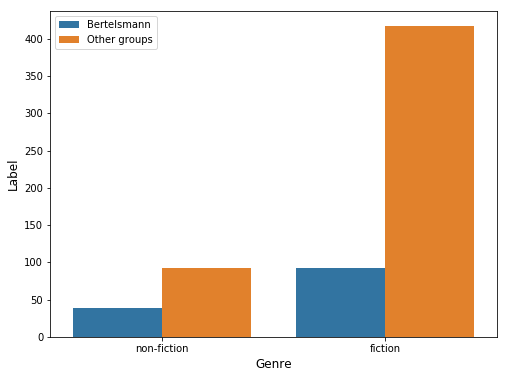

In [10]:
# generate count plot for different groups 
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

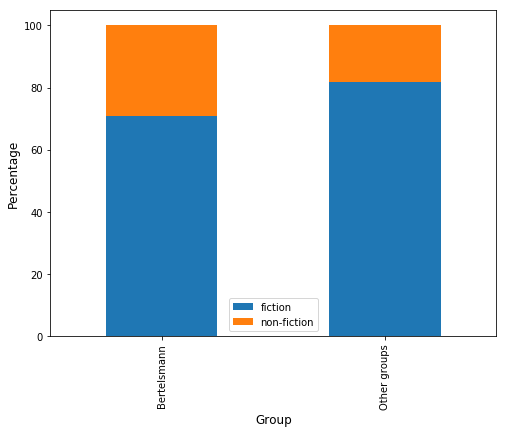

In [11]:
# generate percentage plot for different groups 
plot_percentage_genres(df_ficition_grouped_percentage)

#### Conculsion 
* the percentage of non-fiction books for scholar is higher compared to non-scholars
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [12]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
fiction                  92          417   70.769231    81.925344
non-fiction              38           92   29.230769    18.074656

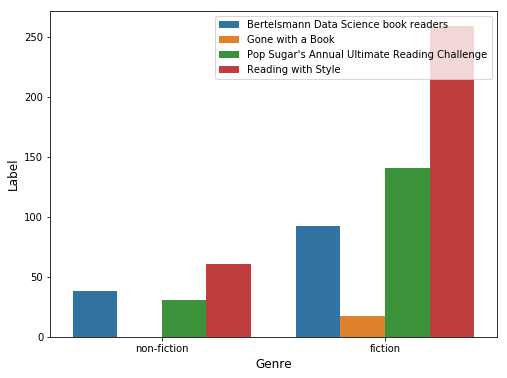

In [13]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

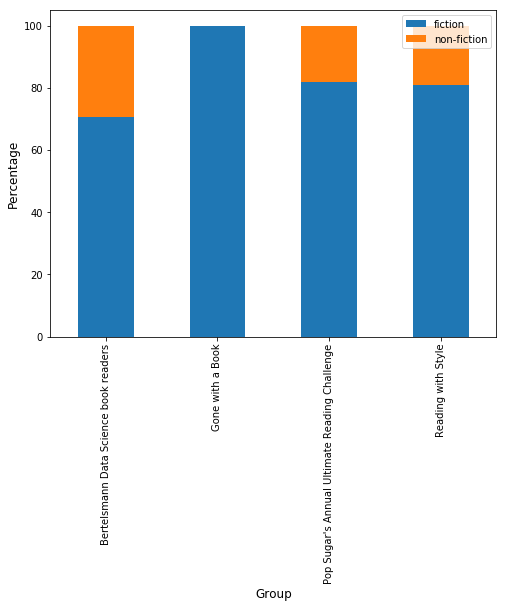

In [14]:
plot_percentage_genres(df_ficition_notgrouped_percentage)

###  2) distribution of different fiction books genres liked by users 
* compare the difference in interest when we split the groups in two by combining all the non-Bertelsmann into one group(other) and Bertelsmann group 
* generate a df summarizing the count and percent of each genre for each group
* generate percentage and count plot for the new group
* compare the groups individiulaly 

In [15]:
comparsion_genres = ['science-fiction','history','classics','fantasy','romance']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
classics                 54          158   29.347826    26.421405
fantasy                  46          122   25.000000    20.401338
history                  34          164   18.478261    27.424749
romance                  17           82    9.239130    13.712375
science-fiction          33           72   17.934783    12.040134

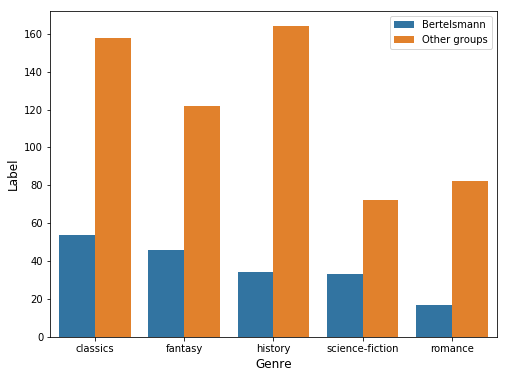

In [16]:
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

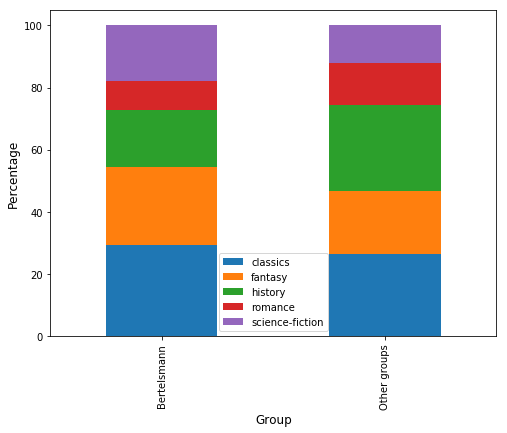

In [17]:
plot_percentage_genres(df_ficition_grouped_percentage)

#### Conculsion 
* the percentage of science-fiction books for scholar is higher compared to non-scholars and a lower percentage of romance books
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [18]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
classics                 54          158   29.347826    26.421405
fantasy                  46          122   25.000000    20.401338
history                  34          164   18.478261    27.424749
romance                  17           82    9.239130    13.712375
science-fiction          33           72   17.934783    12.040134

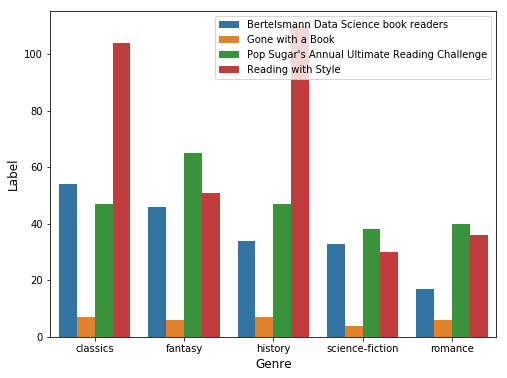

In [19]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

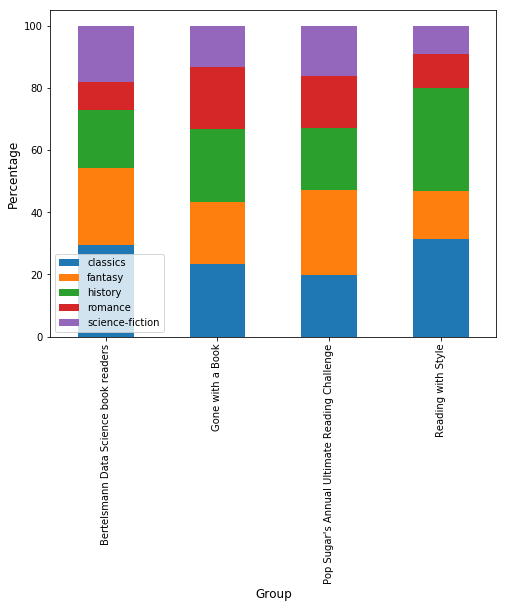

In [20]:
plot_percentage_genres(df_ficition_notgrouped_percentage)

###  3) Adult or young-adult in different groups 
* compare the difference in interest when we split the groups in two by combining all the non-Bertelsmann into one group(other) and Bertelsmann group 
* generate a df summarizing the count and percent of each genre for each group
* generate percentage and count plot for the new group
* compare the groups individiulaly 

In [21]:
comparsion_genres = ['adult','young-adult']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
adult                    29          159   54.716981    66.806723
young-adult              24           79   45.283019    33.193277

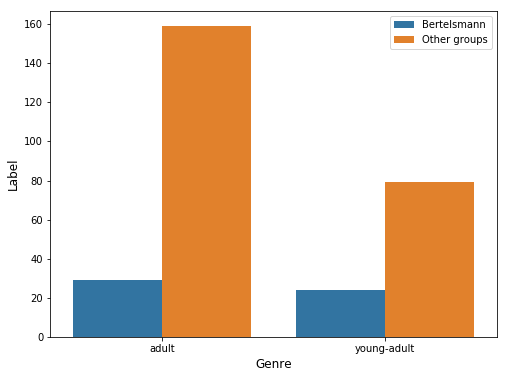

In [22]:
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

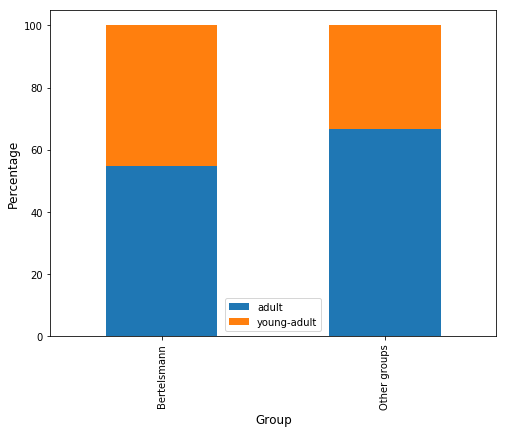

In [23]:
plot_percentage_genres(df_ficition_grouped_percentage)

#### Conculsion 
* the percentage of young-adults books for scholar is higher compared to non-scholars 
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [24]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
adult                    29          159   54.716981    66.806723
young-adult              24           79   45.283019    33.193277

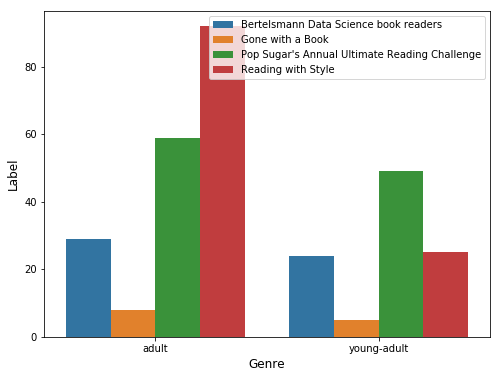

In [25]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

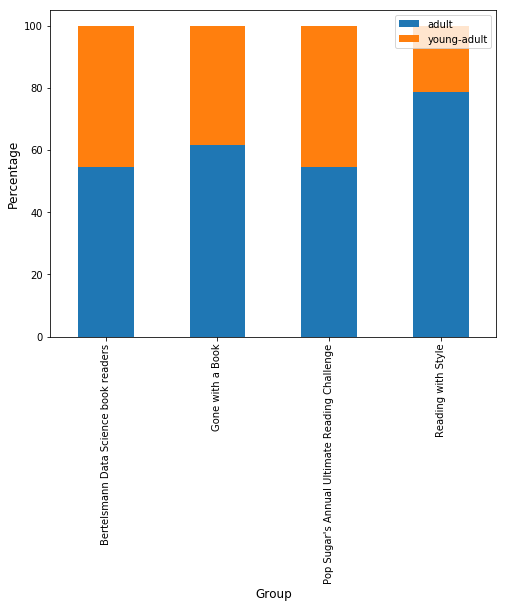

In [26]:
plot_percentage_genres(df_ficition_notgrouped_percentage)

In [27]:
#4) how much we read more personal-development or philosphy in different groups 
comparsion_genres = ['personal-development','philosophy']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified      Bertelsmann Other groups Bertelsmann Other groups
genre                                                                 
personal-development        16.0          NaN   35.555556          NaN
philosophy                  29.0          1.0   64.444444        100.0

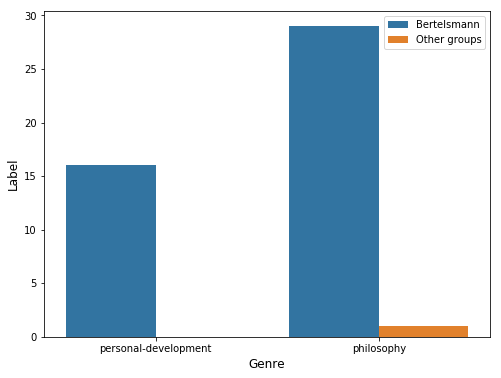

In [28]:
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

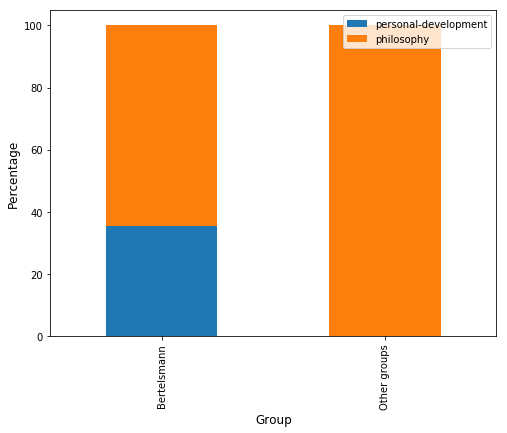

In [29]:
plot_percentage_genres(df_ficition_grouped_percentage)

#### Conculsion 
* the percentage of personal-development books for scholar is higher compared to non-scholars 
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [30]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified      Bertelsmann Other groups Bertelsmann Other groups
genre                                                                 
personal-development        16.0          NaN   35.555556          NaN
philosophy                  29.0          1.0   64.444444        100.0

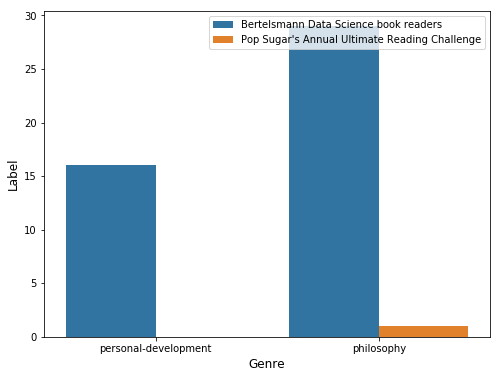

In [31]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

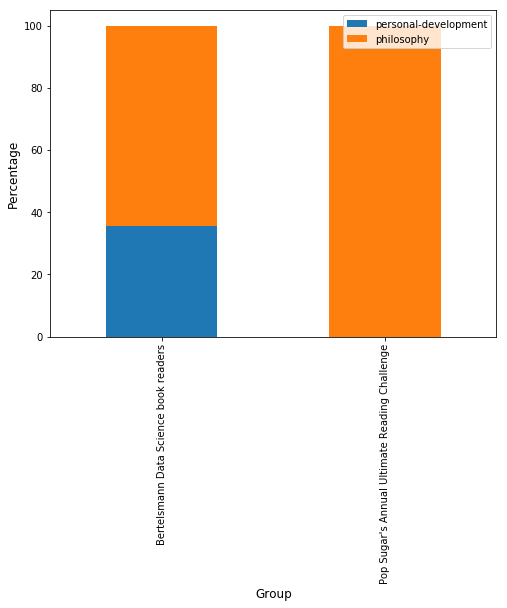

In [32]:
plot_percentage_genres(df_ficition_notgrouped_percentage)

In [33]:
# all the genres together 
comparsion_genres = ['personal-development','philosophy','adult','young-adult','science-fiction','history','classics','fantasy','romance','fiction','non-fiction']
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


count               percentage             
club_classified      Bertelsmann Other groups Bertelsmann Other groups
genre                                                                 
adult                       29.0        159.0    7.038835    11.812779
classics                    54.0        158.0   13.106796    11.738484
fantasy                     46.0        122.0   11.165049     9.063893
fiction                     92.0        417.0   22.330097    30.980684
history                     34.0        164.0    8.252427    12.184250
non-fiction                 38.0         92.0    9.223301     6.835067
personal-development        16.0          NaN    3.883495          NaN
philosophy                  29.0          1.0    7.038835     0.074294
romance                     17.0         82.0    4.126214     6.092125
science-fiction             33.0         72.0    8.009709     5.349183
young-adult                 24.0         79.0    5.825243     5.869242

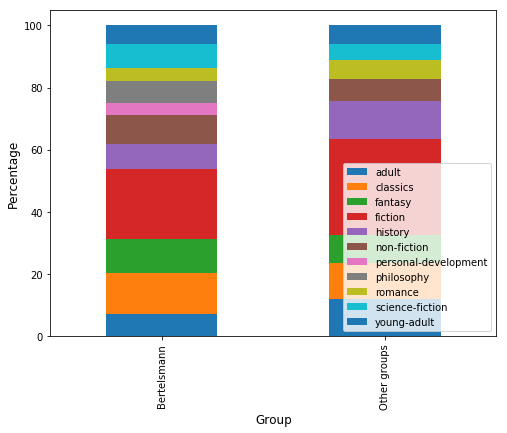

In [34]:
plot_percentage_genres(df_ficition_grouped_percentage)

###  4) rating distribution of books  
* compare the rating of books across groups 
* generate percentage and count plot for the new group
* we can notice for both groups the mean of rating is 4 and range is from 3 -4.6 

In [35]:
df_new_grouped_rating = pd.DataFrame.copy(df[['club_name','avg_rating','title']])
df_new_grouped_rating['club_classified'] = np.where(df_new_grouped_rating['club_name']=='Bertelsmann Data Science book readers', 'Bertelsmann', 'Other groups')
del df_new_grouped_rating['club_name']


In [36]:
df_new_grouped_rating[df_new_grouped_rating['club_classified'] == 'Bertelsmann']['avg_rating'].describe()


count    706.000000
mean       4.035297
std        0.327427
min        3.000000
25%        3.900000
50%        4.045000
75%        4.230000
max        4.620000
Name: avg_rating, dtype: float64

In [37]:
df_new_grouped_rating[df_new_grouped_rating['club_classified'] == 'Other groups']['avg_rating'].describe()


count    2471.000000
mean        3.920749
std         0.293943
min         2.940000
25%         3.800000
50%         3.960000
75%         4.080000
max         4.610000
Name: avg_rating, dtype: float64

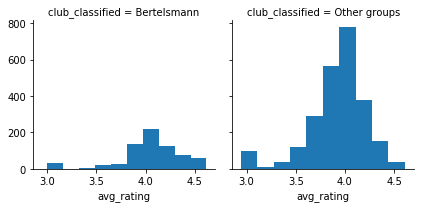

In [38]:
g=sns.FacetGrid(data=df_new_grouped_rating,col='club_classified')
g.map(plt.hist,'avg_rating')


###  5) popularity of books from the ratings count
* are Bertelsmann scholars interested in popular books more?
* compare the rating of books across groups 
* generate percentage plot for the Bertelsmann aganist all other groups 


In [ ]:
df_new_grouped_cnt = pd.DataFrame.copy(df[['club_name','ratings_cnt','title']])
df_new_grouped_cnt['club_classified'] = np.where(df_new_grouped_cnt['club_name']=='Bertelsmann Data Science book readers', 'Bertelsmann', 'Other groups')
del df_new_grouped_cnt['club_name']


In [ ]:
# divide the ratings count into 8 divisons to make it easier to compare 
segmented_count = df_new_grouped_cnt.groupby([pd.qcut(df_new_grouped_cnt['ratings_cnt'], q=8),'club_classified']).count()
segmented_count['title'].unstack()

In [ ]:
# calculate the percentage of each ratings count divison for Bertelsmann and other groups

segement_cnt2 = df_new_grouped_cnt.groupby([pd.qcut(df_new_grouped_cnt['ratings_cnt'], q=10),'club_classified'])['title'].agg({'percentage':'count'})
segement_cnt2_percentage = segement_cnt2.groupby(level='club_classified').apply(lambda x: 100 * x / float(x.sum()))
segement_cnt2_percentage.unstack()

In [ ]:
# plot the percentage of each 
segement_cnt2_percentage.unstack(level=1).plot(kind='bar',  y = 'percentage',figsize = (8,6),stacked = True)
plt.legend(loc='best', fontsize = 10)
plt.xlabel('ratings_cnt', size = 12)
plt.ylabel('Percentage', size = 12)
plt.tick_params(axis='both',which='both',labelsize=10)


##### conculsion
* we divided the ratings count into 8 divisons to make it easier to plot and group the rating count
* we can notice that for books with ratings of 121068 Bertelsmann scholars read more compare to the other groups


### 6) genres popular across the groups 
* what are the top 5 most common genres for each group 
* popular genres for Bertelsmann were: ficition, novel, classics, literature, fantasy while other groups had fiction, novel, history, adult, classics 

In [46]:
df_g_count = df_new_grouped.groupby(["club_classified","genre"])['title'].count()
g_percentage = df_g_count.groupby(level='club_classified').apply(lambda x: 100 * x / float(x.sum()))

g2 = g_percentage.groupby(level=0, group_keys=False)
g2.nlargest(5)

club_classified  genre     
Bertelsmann      fiction       13.031161
                 novel          9.631728
                 classics       7.648725
                 literature     7.082153
                 fantasy        6.515581
Other groups     fiction       16.875759
                 novel          7.001214
                 history        6.636989
                 adult          6.434642
                 classics       6.394172
Name: title, dtype: float64

In [50]:
df_g_count = df.groupby(["club_name","genre"])['title'].count()
g_percentage = df_g_count.groupby(level='club_name').apply(lambda x: 100 * x / float(x.sum()))

g2 = g_percentage.groupby(level=0, group_keys=False)
g2.nlargest(5)

club_name                                      genre      
Bertelsmann Data Science book readers          fiction        13.031161
                                               novel           9.631728
                                               classics        7.648725
                                               literature      7.082153
                                               fantasy         6.515581
Gone with a Book                               fiction        15.596330
                                               novel           9.174312
                                               adult           7.339450
                                               classics        6.422018
                                               history         6.422018
Pop Sugar's Annual Ultimate Reading Challenge  fiction        16.077537
                                               fantasy         7.411631
                                               adult           6.727480
     